In [1]:
from time import time

start = time()

## Regex classifier

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import re


#idea credit https://www.linkedin.com/pulse/regex-one-pattern-rule-them-all-find-bring-darkness-bind-carranza/
class RegexClassifier(BaseEstimator, RegressorMixin):
    """
    Language Classifier using Regular Expressions
    """

    language_regex_dict = {
        'el': r'([\u0370-\u03ff\u1f00-\u1fff]+)\s?',  # Greek
        'en': r'([a-zA-Z]+)\s?',  # English
    }

    # STATIC INITALIZATION BLOCK
    # pre-compie all expressions to save execution time
    for lang in language_regex_dict.keys():
        language_regex_dict[lang] = re.compile(language_regex_dict[lang])


    def __init__(self, include_greeklish=True):
        """
        Initialize a new :class:`RegexClassifier` instance.

        :param include_greeklish: Optional. If True, include Greeklish in the language identification process.
        """
        self.include_greeklish = include_greeklish

    def predict(self, x):
        preds = []

        for text in x:
            pred = "other"

            if self.include_greeklish and \
                re.search(RegexClassifier.language_regex_dict["el"], text) and \
                re.search(RegexClassifier.language_regex_dict["en"], text):
                    pred = "greeklish"
            else:
                for lang_code, regex_pattern in RegexClassifier.language_regex_dict.items():
                    match = re.search(regex_pattern, text)
                    if match:
                        pred = lang_code
                        break
            preds.append(pred)
        return np.array(preds)
    
    def fit(self, x, y):
        return self

In [3]:
# Example usage
user_input_text = ["你好，これはサンプルです。안녕하세요", "this is an english sentence", "δεν αντεχω αλλο"]
detected_language = RegexClassifier().predict(user_input_text)
print(f"Detected Language Code: {detected_language}")

Detected Language Code: ['other' 'en' 'el']


## Defining the Gold Standard


### Greek-English identification dataset

https://aclanthology.org/L06-1229/
https://aclanthology.org/L04-1369/
https://huggingface.co/datasets/papluca/language-identification

In [4]:
import pandas as pd


def dataset_to_pd(dataset_dict: dict) -> pd.DataFrame:
    df_ls = []
    label_array = np.empty(shape=(sum([len(dataset) for dataset in dataset_dict.values()])), dtype=object)
    last_idx = -1

    for label, dataset in dataset_dict.items():
        new_last_idx = len(dataset) + last_idx
        label_array.put(np.arange(last_idx+1, new_last_idx+1, 1), label)
        last_idx = new_last_idx

        df_ls.append(pd.DataFrame(dataset))

    full_df = pd.concat(df_ls, ignore_index=True)
    full_df["set"] = label_array
    full_df.insert(0, "set", full_df.pop("set"))

    return full_df

In [5]:
from datasets import load_dataset


dataset_dict = load_dataset("papluca/language-identification")
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [6]:
lang_df = dataset_to_pd(dataset_dict)
lang_df

,set,labels,text
0,train,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,train,bg,размерът на хоризонталната мрежа може да бъде ...
2,train,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,train,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,train,ru,Он увеличил давление .
...,...,...,...
89995,test,zh,史料很充分，对岸的很多观点与大陆迥异啊。
89996,test,tr,"Örneğin, teşhis Yunanca bir kelimeden alındı (..."
89997,test,vi,Nếu lite/light chỉ đơn giản là mô tả một đặc t...
89998,test,bg,"Например, една щатска столица, която посетихме..."


In [7]:
en_gr_cond = lang_df.labels.eq("el") | lang_df.labels.eq("en")
en_gr_df = lang_df.loc[en_gr_cond, ["labels", "text"]]
en_gr_df

,labels,text
18,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
39,en,Didnt really seem to work much.
40,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
49,en,Highly recommend for those who don't like bein...
75,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
89961,en,"It's super cute, really soft. Print is fine bu..."
89965,en,"One of them worked, the other one didn't. Ther..."
89978,en,I only received one out of the three strikers :(
89982,el,Οι οργανισμοί πρέπει να είναι σε θέση να μετρή...


In [8]:
others_df = lang_df.loc[~en_gr_cond, ["labels", "text"]]
others_df = others_df.sample(15000)
others_df.labels = "other"
others_df

,labels,text
42998,other,"ओह , हाँ ."
81708,other,Sisi sio wahalisi ama kitu ingine lakini
32407,other,St. Catherine đã từng là một tu viện rất giàu ...
19250,other,ให้ สภาพแวดล้อม การ จัดการ การเปลี่ยนแปลง สำหร...
76166,other,Msaada wa kiikolojia hutofautiana na msaada wa...
...,...,...
89959,other,"Bây giờ, đây không phải là vấn đề mà những ngư..."
56687,other,انه رجل جيد .
59087,other,Fortes novos abalos sísmicos abalaram a região...
30994,other,Và rồi sao ?


In [9]:
gold1_df = pd.concat([en_gr_df, others_df], axis=0, ignore_index=True, copy=False)
gold1_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
23995,other,"Bây giờ, đây không phải là vấn đề mà những ngư..."
23996,other,انه رجل جيد .
23997,other,Fortes novos abalos sísmicos abalaram a região...
23998,other,Và rồi sao ?


### Greek-Greeklish identification dataset

In [10]:
head_url = "https://forum.warmane.com"
warmane_url = "https://forum.warmane.com/forumdisplay.php?f=20"

In [11]:
from src.crawling import fetch_soup
from tasks.warmane import parse_warmane_thread
from tqdm import tqdm


threads = []

for page in range(1, 9):
    url = warmane_url + f"&page={page}"
    soup = fetch_soup(url)

    print(f"Processing page {page} of 8...")
    thread_tags = soup.find_all("li", {"class": "threadbit"})
    for thread_tag in tqdm(thread_tags):
        thread = parse_warmane_thread(head_url, thread_tag)
        threads.append(thread)

Processing page 1 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.30it/s]


Processing page 2 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.69it/s]


Processing page 3 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.84it/s]


Processing page 4 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.09it/s]


Processing page 5 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.32it/s]


Processing page 6 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.57it/s]


Processing page 7 of 8...


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  5.33it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=272585


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.55it/s]


Processing page 8 of 8...


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:01<00:00,  5.57it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=278731


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.87it/s]


In [12]:
import itertools

# flatten nested lists 
posts = set(itertools.chain.from_iterable([thread.posts for thread in threads]))
len(posts)

415

In [13]:
import pandas as pd

warmane_df = pd.DataFrame.from_records([post.__dict__ for post in posts], index="id")
warmane_df.reply_to = warmane_df.reply_to.fillna(-1).astype(int)
warmane_df

,thread_id,author,contents,date,reply_to
id,,,,,
2926596,384475,Ripsin,"Kalhspera paides,\n\r\nEimai arketo kairo ston...",2018-05-22,-1
2473988,300013,v4gflo,geia sas.psaxnw ellhniko guild ston Deathwing ...,2015-06-17,-1
2420747,290921,AlexPan,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...",2015-03-24,-1
2981903,399822,xAchillesGate4x,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...,2019-03-03,-1
2879517,371804,Csdas,Opoios gnwrizei kati as mou kanei /w Dremoria ...,2017-11-29,-1
...,...,...,...,...,...
2877428,353812,Shiverbro,kalos private aksizei na ksekiniseis paidia?,2017-11-21,2875915
3069941,423611,crystallenia898,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...,2020-07-26,3068345
2801654,350071,Draculation,Bump! ICC25 6/12,2017-05-07,2795443


In [14]:
empty_contents = warmane_df.contents.apply(lambda x: x.isspace() | len(x)==0)
warmane_df[empty_contents]

,thread_id,author,contents,date,reply_to
id,,,,,
3082464,427259,malakas17,,2020-10-20,3081822
3113236,427259,malakas17,,2021-05-12,3113009
3099161,431660,malakas17,,2021-02-10,3096432
3113819,427259,malakas17,,2021-05-16,3113236
3099593,427259,boonick,,2021-02-14,3093400
3081820,427259,malakas17,,2020-10-16,3080427
3081822,427259,malakas17,,2020-10-16,3081820


In [15]:
warmane_df = warmane_df[~empty_contents]

In [16]:
from src.crawling import ChromeDriverManager, jupyter_options


ChromeDriverManager.set_options(jupyter_options())

In [17]:
from tasks.youtube import extract_search_results, extract_comments, scrape_youtube


greek_yt_urls = ["https://www.youtube.com/watch?v=4Y2gxkqbsbA", 
       "https://www.youtube.com/watch?v=31LcJ9gqQvA",
       "https://www.youtube.com/watch?v=1cZXAQ1JEJo",
       "https://www.youtube.com/watch?v=x7lnS6jMS64",
       "https://www.youtube.com/watch?v=ImilczGN-00"]
scrape_results = []

for url in tqdm(greek_yt_urls):
    scrape_results.append(scrape_youtube(ChromeDriverManager.get(), url, max_scrolls=10, verbose=False))

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Creating new driver...
New driver online.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:25<00:00, 17.14s/it]


In [18]:
from tasks.youtube import extract_comments


all_comments = []
for result in scrape_results:
    comments, _ = extract_comments(result)
    all_comments += comments

all_comments = pd.Series(all_comments)

In [19]:
greeklish_series = pd.concat([warmane_df.contents, all_comments])
greeklish_series

2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
                                 ...                        
772                                        Gianni παίξε Pubg
773                                                    Πρώτη
774                                                    First
775                                             First of all
776                                                   Πρώτος
Length: 1185, dtype: object

In [20]:
conditions = (greeklish_series.apply(lambda x: len(x) != 0)) & \
                (greeklish_series.apply(lambda x: "RRR" not in x)) & \
                (greeklish_series.apply(lambda x: "PPP" not in x)) & \
                (greeklish_series.apply(lambda x: "First" not in x))
cleared_greeklish_series = greeklish_series[conditions]
cleared_greeklish_series

2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
                                 ...                        
770                                               Πρώτο like
771                                                   Πρώτος
772                                        Gianni παίξε Pubg
773                                                    Πρώτη
776                                                   Πρώτος
Length: 1165, dtype: object

In [21]:
regex_model = RegexClassifier(include_greeklish=False)
preds = regex_model.predict(cleared_greeklish_series)

In [22]:
cleared_greeklish_series[preds=="greeklish"]

Series([], dtype: object)

In [23]:
cleared_greeklish_series[preds=="en"]

2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
2959390               Bubblethesap Icecrown wotlk horde belf
2947119    den se vrisko kane add evvi  .\nmou leei den u...
                                 ...                        
756                                         Epitelous amogus
761        Ante Pali me ta atoma pou einai first.... Mhn ...
763                                                      Lol
764                                             na xanapexis
769                                                     Hafa
Length: 461, dtype: object

In [24]:
cleared_greeklish_series[preds=="el"]

2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2959391    Καλησπερα θα πας στις ιδιότητες (properties) σ...
2719776    Originally Posted by celphecil\n\nΚαλησπέρα Σω...
2971700    Ελληνικο guild , ψαχνουμε ατομα για runs ICC10...
                                 ...                        
770                                               Πρώτο like
771                                                   Πρώτος
772                                        Gianni παίξε Pubg
773                                                    Πρώτη
776                                                   Πρώτος
Length: 697, dtype: object

In [25]:
labels = np.where(preds=="en", "greeklish", "el")
gold2_df = pd.DataFrame({"labels": labels, "text": cleared_greeklish_series})
gold2_df

,labels,text
2926596,greeklish,"Kalhspera paides,\n\r\nEimai arketo kairo ston..."
2473988,greeklish,geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747,el,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \..."
2981903,el,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517,greeklish,Opoios gnwrizei kati as mou kanei /w Dremoria ...
...,...,...
770,el,Πρώτο like
771,el,Πρώτος
772,el,Gianni παίξε Pubg
773,el,Πρώτη


In [26]:
gold_df = pd.concat([gold1_df, gold2_df])
gold_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
770,el,Πρώτο like
771,el,Πρώτος
772,el,Gianni παίξε Pubg
773,el,Πρώτη


In [27]:
import os


OUTPUT_DIR = "output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file, encoding = 'utf8')
    print(f"File saved successfully as {file}")

In [28]:
csv_output(gold_df, "gold.csv")

File saved successfully as output\gold.csv


## Youtube Crawling

In [29]:
from tasks.youtube import extract_search_results, extract_comments


# "greek songs" search in Greek
song_search_url = "https://www.youtube.com/results?search_query=%CE%B5%CE%BB%CE%BB%CE%B7%CE%BD%CE%B9%CE%BA%CE%B1+%CF%84%CF%81%CE%B1%CE%B3%CE%BF%CF%85%CE%B4%CE%B9%CE%B1"
search_soup = scrape_youtube(ChromeDriverManager.get(), song_search_url, max_scrolls=5, verbose=True)
results_search_song = extract_search_results(search_soup)

Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...


In [30]:
gaming_search_url = "https://www.youtube.com/results?search_query=greek+fortnite"
gaming_soup = scrape_youtube(ChromeDriverManager.get(), gaming_search_url, max_scrolls=5, verbose=True)
results_search_gaming = extract_search_results(gaming_soup)

Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...


In [31]:
results_df = pd.DataFrame({"title": results_search_song[0] + results_search_gaming[0],
                           "link":  results_search_song[1] + results_search_gaming[1],
                          "source": np.array(len(results_search_song[0])*["song"] + len(results_search_gaming[0])*["gaming"]) })
results_df

,title,link,source
0,"\n\nΠου 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημέ...",/watch?v=OdX0y96UPEA&pp=ygUjzrXOu867zrfOvc65zr...,song
1,\n\nGreek Hits 2023 | Non-Stop Mix by Elegant ...,/watch?v=RcSAggke-_U&pp=ygUjzrXOu867zrfOvc65zr...,song
2,\n\nΜουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χ...,/watch?v=p5g82ta4sTk&pp=ygUjzrXOu867zrfOvc65zr...,song
3,\n\n00's GREEK MIX | KAPSOURA EDITION\n,/watch?v=isCeE38TrXA&pp=ygUjzrXOu867zrfOvc65zr...,song
4,\n\n40 ελληνικά τραγούδια από τα 60's (by Elia...,/watch?v=WIiJc6_4khQ&pp=ygUjzrXOu867zrfOvc65zr...,song
...,...,...,...
257,\n\nΜΕ SCAMMARE ΚΟΡΙΤΣΙ🤭😂(SCAMMER GETS SCAMMED...,/watch?v=ExbSJygJtTE&pp=ygUOZ3JlZWsgZm9ydG5pdG...,gaming
258,\n\nWINS ΜΟΝΟ ΜΕ SKYBASE ΣΤΟ NEW SEASON! (Fort...,/watch?v=Ftj64tji0ao&pp=ygUOZ3JlZWsgZm9ydG5pdG...,gaming
259,\n\n1 VS 1 CHALLENGE ΜΕ ΤΗΝ ΚΩΝΣΤΑΝΤΙΝΑ ΑΠΟ Pl...,/watch?v=64NObRZWREA&pp=ygUOZ3JlZWsgZm9ydG5pdG...,gaming
260,\n\nΈγινα Καλύτερος ή Μπα? (Fortnite: Battle R...,/watch?v=s3gVQ10aJoQ&pp=ygUOZ3JlZWsgZm9ydG5pdG...,gaming


In [32]:
results_df.title = results_df.title.apply(lambda x: x.strip())
results_df.link = results_df.link.apply(lambda x: "https://www.youtube.com" + x) 
results_df

,title,link,source
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song
1,Greek Hits 2023 | Non-Stop Mix by Elegant Gree...,https://www.youtube.com/watch?v=RcSAggke-_U&pp...,song
2,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song
3,00's GREEK MIX | KAPSOURA EDITION,https://www.youtube.com/watch?v=isCeE38TrXA&pp...,song
4,40 ελληνικά τραγούδια από τα 60's (by Elias),https://www.youtube.com/watch?v=WIiJc6_4khQ&pp...,song
...,...,...,...
257,ΜΕ SCAMMARE ΚΟΡΙΤΣΙ🤭😂(SCAMMER GETS SCAMMED){GR...,https://www.youtube.com/watch?v=ExbSJygJtTE&pp...,gaming
258,WINS ΜΟΝΟ ΜΕ SKYBASE ΣΤΟ NEW SEASON! (Fortnite...,https://www.youtube.com/watch?v=Ftj64tji0ao&pp...,gaming
259,1 VS 1 CHALLENGE ΜΕ ΤΗΝ ΚΩΝΣΤΑΝΤΙΝΑ ΑΠΟ PlaySt...,https://www.youtube.com/watch?v=64NObRZWREA&pp...,gaming
260,Έγινα Καλύτερος ή Μπα? (Fortnite: Battle Royal...,https://www.youtube.com/watch?v=s3gVQ10aJoQ&pp...,gaming


In [33]:
greeklish_model = RegexClassifier(include_greeklish=True)
preds = greeklish_model.predict(results_df.title)
gr_res_df = results_df[(preds != "en") & (preds != None)]
gr_res_df

,title,link,source
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song
2,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song
4,40 ελληνικά τραγούδια από τα 60's (by Elias),https://www.youtube.com/watch?v=WIiJc6_4khQ&pp...,song
7,Όμορφα ελληνικά τραγούδια,https://www.youtube.com/watch?v=UIfND1RykJc&pp...,song
9,Τα λαϊκά που αγαπήσαμε - 100 ιστορικά τραγούδι...,https://www.youtube.com/watch?v=OuY-cviIIqM&pp...,song
...,...,...,...
257,ΜΕ SCAMMARE ΚΟΡΙΤΣΙ🤭😂(SCAMMER GETS SCAMMED){GR...,https://www.youtube.com/watch?v=ExbSJygJtTE&pp...,gaming
258,WINS ΜΟΝΟ ΜΕ SKYBASE ΣΤΟ NEW SEASON! (Fortnite...,https://www.youtube.com/watch?v=Ftj64tji0ao&pp...,gaming
259,1 VS 1 CHALLENGE ΜΕ ΤΗΝ ΚΩΝΣΤΑΝΤΙΝΑ ΑΠΟ PlaySt...,https://www.youtube.com/watch?v=64NObRZWREA&pp...,gaming
260,Έγινα Καλύτερος ή Μπα? (Fortnite: Battle Royal...,https://www.youtube.com/watch?v=s3gVQ10aJoQ&pp...,gaming


In [34]:
from selenium.common.exceptions import JavascriptException
import bs4


def scrape(urls: list[str]) -> list[tuple[str, bs4.BeautifulSoup]]:
    scrape_results = []
    
    print("Scraping videos...")
    for url in tqdm(urls):
        try:
            scrape_results.append((url, scrape_youtube(ChromeDriverManager.get(), url, max_scrolls=10, scroll_wait_secs=1.3, verbose=False)))
        except JavascriptException:
            continue
        except Exception as e:
            print(e)
            continue  
    return scrape_results


def process_scraped(scrape_results: list[tuple[str, bs4.BeautifulSoup]]) -> pd.DataFrame:
    scraped_urls = []
    comments = []
    dates = []
    
    print("Processing comments...")
    print(type(scrape_results[0]))
    for url, result in tqdm(scrape_results):
        if result is not None:
            new_comments, new_dates = extract_comments(result)
            comments += new_comments
            dates += new_dates
            scraped_urls += ([url] * len(new_comments))
    return pd.DataFrame({"link": scraped_urls, "text": comments, "date": dates})


def filter_comments(df: pd.DataFrame) -> pd.DataFrame:
    preds = greeklish_model.predict(df.text)
    mask = ((preds != "el") & (preds != "greeklish"))
    return comments_df[mask]

In [35]:
max_videos = 150
urls = gr_res_df.link.sample(max_videos) if len(gr_res_df.link) > max_videos else gr_res_df.link

scraped = scrape(urls)
comments_df = process_scraped(scraped)

comments_df.date = comments_df.date.apply(lambda x: x.date() if x is not None else None)
comments_df = filter_comments(comments_df)
crawl_df = pd.merge(gr_res_df, comments_df, how="inner", on="link")

Scraping videos...


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [33:53<00:00, 13.56s/it]


Processing comments...
<class 'tuple'>


100%|████████████████████████████████████████████████████████████████████████████████| 141/141 [01:12<00:00,  1.96it/s]


In [36]:
ChromeDriverManager.quit()

In [37]:
csv_output(crawl_df, "temp.csv")

File saved successfully as output\temp.csv


## Language Identification

https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he
https://gking.harvard.edu/files/abs/0s-abs.shtml
https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data


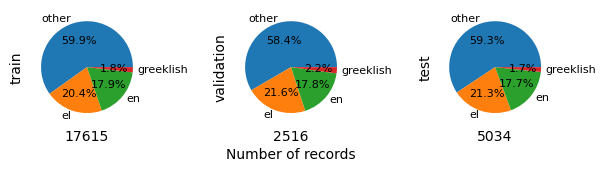

In [38]:
from src.ml import train_test_val_split
import matplotlib.pyplot as plt


data_train, data_val, data_test = train_test_val_split(gold_df, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2,
                                                        random_state=42, stratify_col="labels")
# code block from Ioannis Pavlopoulos
axes = pd.DataFrame({"train": data_train.labels.value_counts(),
              "validation": data_val.labels.value_counts(),
              "test": data_test.labels.value_counts()}
            ).plot.pie(subplots=True, 
                       textprops={'fontsize': 8},
                       autopct=f'%1.1f%%', # print percent% results 
                       legend=False)

axes[0].set_xlabel(data_train.shape[0])
axes[1].set_xlabel(data_val.shape[0])
axes[2].set_xlabel(data_test.shape[0])

axes[1].text(0, -2, 'Number of records', ha='center')

plt.tight_layout(pad=2.0)
plt.show()

In [39]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


vectorizer = TfidfVectorizer().fit(data_train.text)
x_train = vectorizer.transform(data_train.text)
y_train = data_train.labels
x_val = vectorizer.transform(data_val.text)
y_val = data_val.labels
x_test = vectorizer.transform(data_test.text)
y_test = data_test.labels

In [40]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res

### Dummy Classifier

In [41]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings


def get_statistics(y_test, y_pred):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        print(f"Macro F1: {f1_score(y_test, y_pred, average='macro', zero_division=0)}")
        print(classification_report(y_test, y_pred, zero_division=0))
        ConfusionMatrixDisplay.from_predictions(y_test, 
                                                y_pred, 
                                                colorbar=True)
        plt.show()

Macro F1: 0.18615960099750622
              precision    recall  f1-score   support

          el       0.00      0.00      0.00      1072
          en       0.00      0.00      0.00       891
   greeklish       0.00      0.00      0.00        85
       other       0.59      1.00      0.74      2986

    accuracy                           0.59      5034
   macro avg       0.15      0.25      0.19      5034
weighted avg       0.35      0.59      0.44      5034



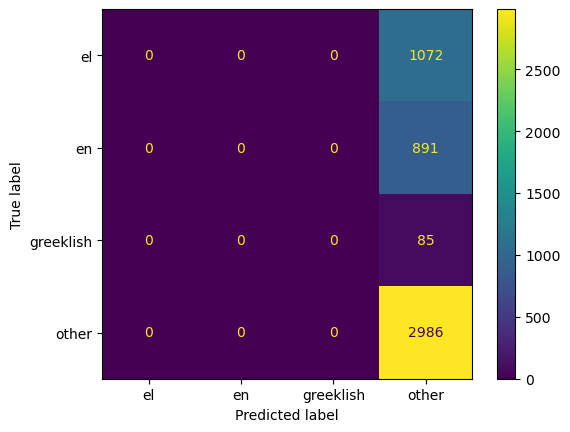

In [42]:
from sklearn.dummy import DummyClassifier, DummyRegressor


majority = DummyClassifier(strategy="most_frequent")
majority.fit(x_train, y_train)
majority_res = majority.predict(x_test)

get_statistics(y_test, majority_res)

### Regex Classification

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    regex_model = RegexClassifier()
    res = cross_val_res(regex_model, data_train.text, y_train, scoring="f1_macro")
    print(f"Regex Classifier mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Regex Classifier mean macro F1: 0.4611, std: 0.4631


Macro F1: 0.4602393032990586
              precision    recall  f1-score   support

          el       1.00      0.70      0.83      1072
          en       0.31      1.00      0.48       891
   greeklish       0.00      0.00      0.00        85
       other       1.00      0.37      0.54      2986

    accuracy                           0.55      5034
   macro avg       0.58      0.52      0.46      5034
weighted avg       0.86      0.55      0.58      5034



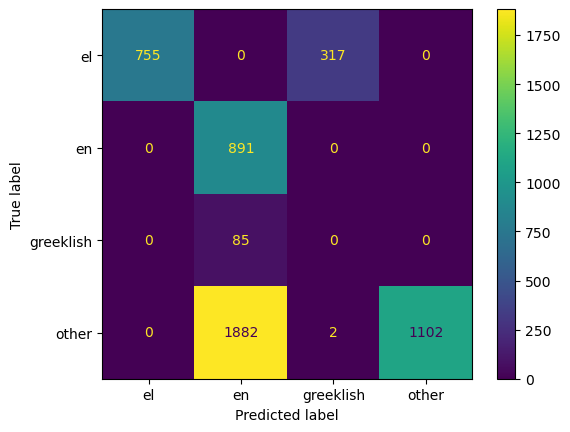

In [44]:
regex_model = RegexClassifier(include_greeklish=True).fit(data_train.text, y_train)
regex_res = regex_model.predict(data_test.text)
get_statistics(y_test, regex_res)

### Naive Bayes

https://towardsdatascience.com/naive-bayes-classifiers-for-text-classification-be0d133d35ba

In [45]:
from sklearn.naive_bayes import MultinomialNB


naive_x_train = x_train.toarray()
naive_x_test = x_test.toarray()

naive_model = MultinomialNB()
res = cross_val_res(naive_model, naive_x_train, y_train, cv=5)
print(f"Naive Bayes mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Naive Bayes mean macro F1-score 0.7797, std: 0.7751


Macro F1: 0.814026959895445
              precision    recall  f1-score   support

          el       0.99      0.98      0.98      1072
          en       0.97      1.00      0.99       891
   greeklish       1.00      0.18      0.30        85
       other       0.97      1.00      0.98      2986

    accuracy                           0.98      5034
   macro avg       0.99      0.79      0.81      5034
weighted avg       0.98      0.98      0.97      5034



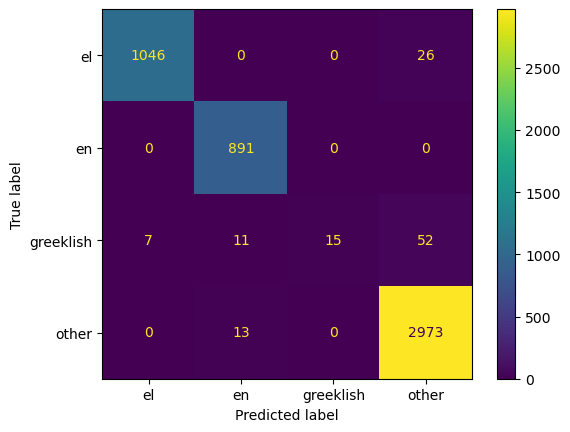

In [46]:
from sklearn.naive_bayes import MultinomialNB


naive_model = MultinomialNB().fit(naive_x_train, y_train)
naive_res = naive_model.predict(naive_x_test)

get_statistics(y_test, naive_res)

### Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.8198, std: 0.8812


Macro F1: 0.879979228132573
              precision    recall  f1-score   support

          el       1.00      0.92      0.96      1072
          en       0.99      0.96      0.98       891
   greeklish       0.97      0.45      0.61        85
       other       0.95      1.00      0.97      2986

    accuracy                           0.97      5034
   macro avg       0.98      0.83      0.88      5034
weighted avg       0.97      0.97      0.96      5034



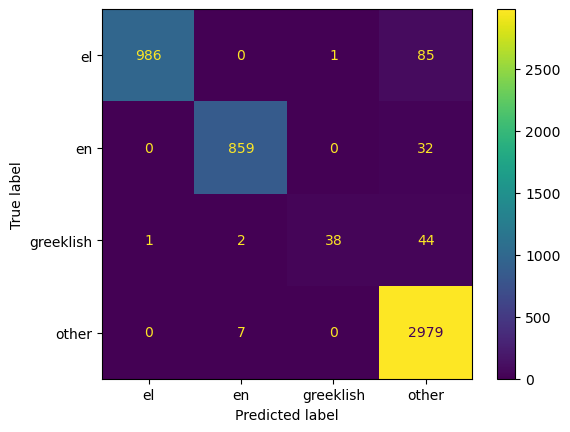

In [48]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

get_statistics(y_test, lr_res)

### Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Macro F1: 0.9427718287342222
              precision    recall  f1-score   support

          el       1.00      0.97      0.98      1072
          en       0.97      1.00      0.99       891
   greeklish       0.97      0.71      0.82        85
       other       0.98      0.99      0.99      2986

    accuracy                           0.98      5034
   macro avg       0.98      0.92      0.94      5034
weighted avg       0.98      0.98      0.98      5034



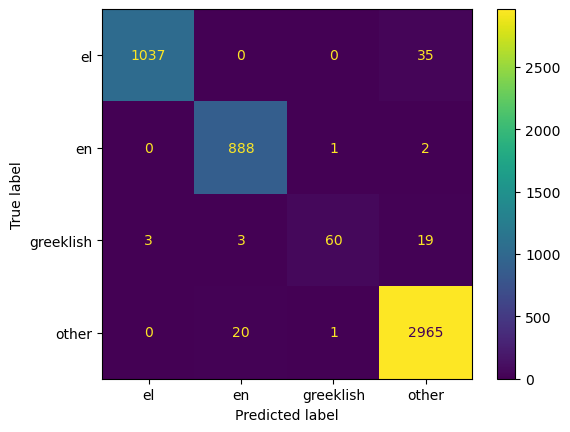

In [49]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=100, 
                                      n_jobs=-1, 
                                      criterion="entropy", 
                                      verbose=1).fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
get_statistics(y_test, forest_pred)

### Adaboost

Macro F1: 0.8398085862929566
              precision    recall  f1-score   support

          el       1.00      0.88      0.93      1072
          en       0.98      0.97      0.98       891
   greeklish       0.68      0.38      0.48        85
       other       0.94      0.99      0.96      2986

    accuracy                           0.95      5034
   macro avg       0.90      0.80      0.84      5034
weighted avg       0.95      0.95      0.95      5034



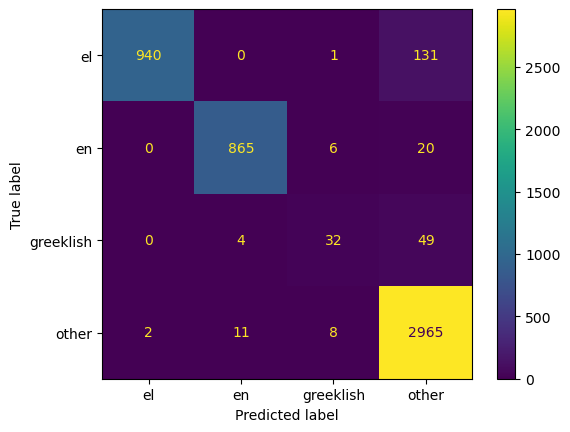

In [50]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=100).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
get_statistics(y_test, ada_pred)

In [51]:
missed = y_test != ada_pred
pd.DataFrame({"predicted": ada_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
4743,other,en,Can definitely save your azz but cheap plastic...
9897,greeklish,other,To także kwestia gustu.
22997,en,other,I can ' t be a ! ! ! ! ! ! hii ilikuwa too muc...
8174,other,el,Οι αλλοδαποί αγρότες μετακινούνται συχνά στις ...
1035,other,el,Ποιος παραδίδει τι είδους παρέμβαση
...,...,...,...
1703,other,el,Έχεις πολύ καιρό στη βόρεια Καρολίνα .
2826,other,el,Φαίνεται ότι θα είχες πολύ πιο ευσυνείδητος ευ...
534,other,el,Υπάρχει ένα voice acting που λέει ότι της αρέσ...
6181,other,el,Οι κυνικοί βρυχήθηκε ότι ο χίτσενς είχε στόχο ...


In [52]:
missed = y_test != forest_pred
pd.DataFrame({"predicted": forest_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
9897,greeklish,other,To także kwestia gustu.
22997,en,other,I can ' t be a ! ! ! ! ! ! hii ilikuwa too muc...
2938120,other,greeklish,Efoson dn apantise kaneis eftia3a egw ena kant...
2968333,other,greeklish,aoua aoua aoua
685,other,greeklish,gg
...,...,...,...
1444,other,el,"Τίποτα , κυρία κάβεντις ;"
11361,en,other,Oh no no they ' ve got watu wa kujitolea .
175,other,el,0:59 ΜΛΚΣ ΚΛΑΙΩΩ
238,other,greeklish,2:06 HAHAHAHHAHAAHAH


### Hyperparameter tuning

In [53]:
estimators = []
scores = []

for n_estimators in tqdm([int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]):
    estim = RandomForestClassifier(n_estimators=n_estimators, 
                                  n_jobs=-1, 
                                  criterion="entropy").fit(x_train, y_train)
    score = f1_score(y_val, estim.predict(x_val), average='macro', zero_division=0)

    estimators.append(estim)
    scores.append(score)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [08:30<00:00, 102.07s/it]


In [54]:
best_model = estimators[np.argmax(scores)]
print(f"Best model {best_model} with macro F1 score of {max(scores)}")

Best model RandomForestClassifier(criterion='entropy', n_jobs=-1) with macro F1 score of 0.9528831734027151


### Annotating the operational dataset

In [55]:
x_oper = vectorizer.transform(crawl_df.text)
crawl_df["language"] = best_model.predict(x_oper)

In [56]:
crawl_df

,title,link,source,text,date,language
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song,"Great selection, one more time. THANKS!",2023-07-27,en
1,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song,,2023-07-27,other
2,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song,,2023-09-27,other
3,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song,️,2023-07-27,other
4,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,Încă o zi petrecută cu muzica voastră fantas...,2022-11-27,other
...,...,...,...,...,...,...
3450,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,Fake,2023-11-18,other
3451,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,malaka einai gia ton poutso to stisimo tou vinteo,2023-11-23,greeklish
3452,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,KALITERA,2023-11-19,other
3453,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,o monos youtuber pou dn exei bgalei pote fake ...,2023-11-18,greeklish


In [57]:
csv_output(crawl_df, "crawl.csv")

File saved successfully as output\crawl.csv


### Exploring the operational dataset

In [58]:
RESOURCE_OUTPUT = "results"

def save_plot(filename):
    path = os.path.join(RESOURCE_OUTPUT, filename)
    plt.savefig(path, bbox_inches="tight")
    print(f"Figured saved to " + path)

Figured saved to results\lang_dis.png


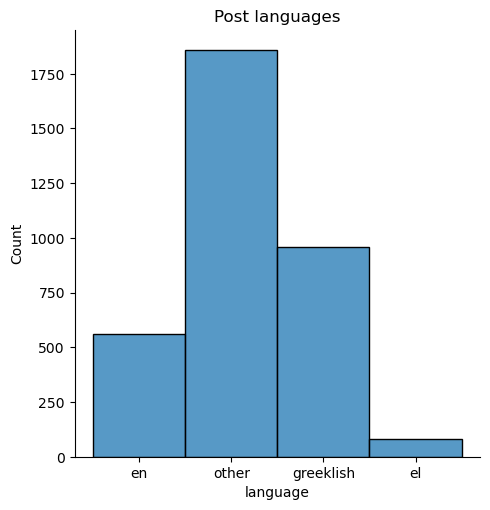

In [59]:
import seaborn as sns


sns.displot(crawl_df.language)
save_plot("lang_dis.png")
plt.title("Post languages")
plt.show()

In [60]:
languages = np.unique(crawl_df.language)

lang_col = []
len_col = []

for language in languages:
    comments_text = crawl_df.loc[crawl_df.language == language, "text"]
    comments_length = comments_text.apply(lambda x: len(x))
    
    lang_col += [language] * len(comments_length)
    len_col += list(comments_length)

len_df = pd.DataFrame({"language": lang_col, "comment_length": len_col})

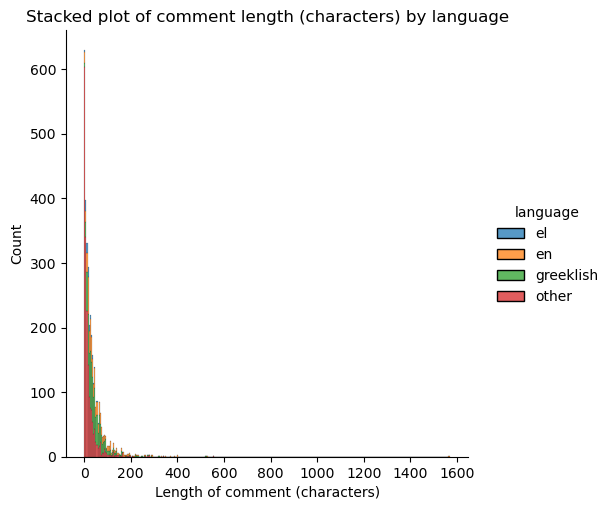

In [61]:
sns.displot(len_df, x="comment_length", hue="language", multiple="stack")
plt.title("Stacked plot of comment length (characters) by language")
plt.xlabel("Length of comment (characters)")
plt.show()

Figured saved to results\length_dis.png


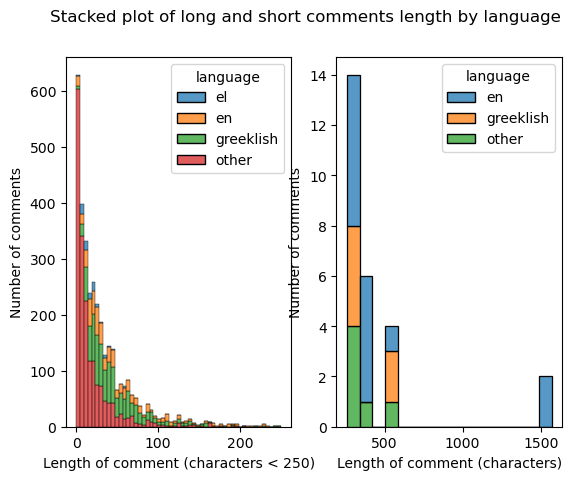

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.histplot(len_df[len_df.comment_length<=250] , x="comment_length", hue="language", multiple="stack", ax=ax1)
ax1.set_xlabel("Length of comment (characters < 250)")
ax1.set_ylabel("Number of comments")

sns.histplot(len_df[len_df.comment_length>250] , x="comment_length", hue="language", multiple="stack", ax=ax2)
ax2.set_xlabel("Length of comment (characters)")
ax2.set_ylabel("Number of comments")

fig.suptitle("Stacked plot of long and short comments length by language")
save_plot("length_dis.png")
plt.show()

In [63]:
len_df.iloc[np.argmax(len_df.comment_length)]

language            en
comment_length    1570
Name: 324, dtype: object

In [64]:
emoji_pattern = re.compile(
    r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF'
    r'\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF'
    r'\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\u2600-\u26FF\u2700-\u27BF'
    r'\u2B50\u2B06\u2934\u2935\u2B05\u2194-\u2199\u21A9\u21AA\u2139\u2328'
    r'\u23CF\u23E9-\u23F3\u231A\u23F8-\u23FA\u231B\u23F0\u231A\u1F004'
    r'\u1F0CF\u1F18E\u3030\u303D]'
)

emojis_col = []

for language in languages:
    comments_text = crawl_df.loc[crawl_df.language == language, "text"]
    comments_length = comments_text.apply(lambda x: len(emoji_pattern.findall(x)))

    emojis_col += list(comments_length)

emoji_df = pd.DataFrame({"language": lang_col, "emojis": emojis_col})

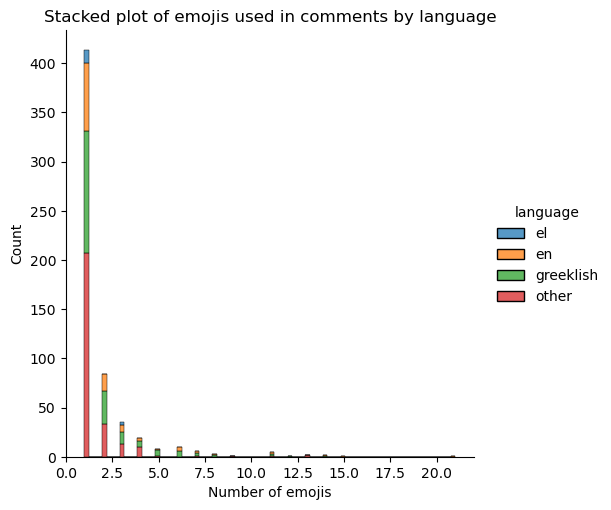

In [65]:
sns.displot(emoji_df[emoji_df.emojis > 0] , x="emojis", hue="language", multiple="stack")
plt.title("Stacked plot of emojis used in comments by language")
plt.xlabel("Number of emojis")
plt.show()

Figured saved to results\length_dis.png


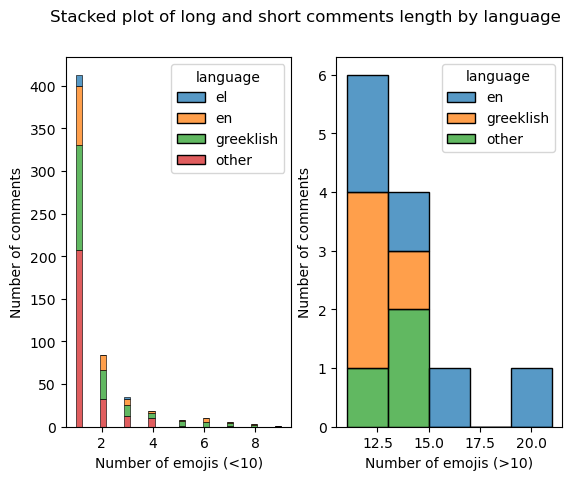

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(emoji_df[(emoji_df.emojis > 0) & (emoji_df.emojis < 10)] , x="emojis", hue="language", multiple="stack", ax=ax1)
ax1.set_xlabel("Number of emojis (<10)")
ax1.set_ylabel("Number of comments")

sns.histplot(emoji_df[emoji_df.emojis > 10] , x="emojis", hue="language", multiple="stack", ax=ax2)
ax2.set_xlabel("Number of emojis (>10)")
ax2.set_ylabel("Number of comments")

fig.suptitle("Stacked plot of long and short comments length by language")
save_plot("length_dis.png")
plt.show()

In [69]:
date_df = crawl_df.groupby(["date", "language"]).count()
date_df

title  link  source  text
date       language                            
2015-11-27 el             1     1       1     1
           greeklish      3     3       3     3
           other          3     3       3     3
2016-11-27 en             2     2       2     2
           other          1     1       1     1
...                     ...   ...     ...   ...
2023-11-25 other         15    15      15    15
2023-11-26 en             2     2       2     2
           greeklish      1     1       1     1
           other         14    14      14    14
2023-11-27 other          2     2       2     2

[113 rows x 4 columns]

Figured saved to results\time_plot.png


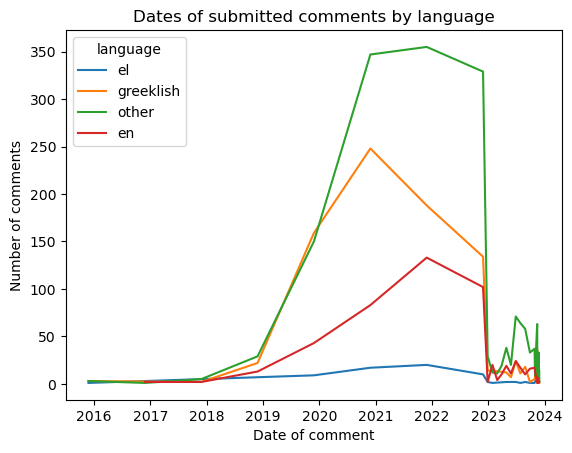

In [71]:
sns.lineplot(x="date", y="text", hue="language", data=date_df)
plt.title("Dates of submitted comments by language")
plt.xlabel("Date of comment")
plt.ylabel("Number of comments")

save_plot("time_plot.png")
plt.show()

In [72]:
print(f"Notebook executed in {int((time()-start)// 60)} minutes and {(time()-start) % 60:.1f} seconds")

Notebook executed in 63 minutes and 9.5 seconds
